In [1]:
# import pyspark.sql.functions as F
# from datetime import datetime, timedelta, date
# from pyspark.sql.types import TimestampType
# from pyspark.sql.functions import sum, to_date, col, when, month, dayofmonth, explode, array, struct, expr, lit , avg
import geopandas as gpd
# import matplotlib.pyplot as plt
from shapely import wkt, Point

import pandas as pd
import os

In [2]:
#load geojson polygon file
cells = gpd.read_file(f"../data/neerslag_ai/polygons_irc.geojson")
cells.index = cells["index"]
cells = cells.drop(columns=['index'])
cells

,geometry
index,
polygon_0,"POLYGON ((72370.233 420696.363, 73323.192 4206..."
polygon_1,"POLYGON ((73323.192 420610.729, 74276.142 4205..."
polygon_2,"POLYGON ((74276.142 420525.047, 75229.083 4204..."
polygon_3,"POLYGON ((75229.083 420439.316, 76182.016 4203..."
polygon_4,"POLYGON ((76182.016 420353.537, 77134.939 4202..."
...,...
polygon_3545,"POLYGON ((130906.100 368332.151, 131856.103 36..."
polygon_3546,"POLYGON ((131856.103 368243.772, 132806.098 36..."
polygon_3547,"POLYGON ((132806.098 368155.346, 133756.083 36..."


<Axes: >

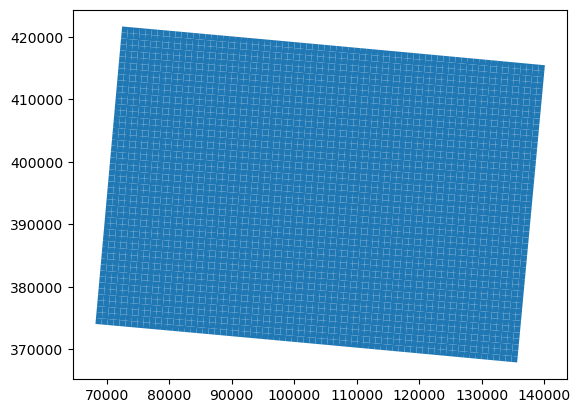

In [3]:
# Create a GeoDataFrame from the Pandas DataFrame
cells = gpd.GeoDataFrame(cells, geometry="geometry")

# Define the RD New and WGS84 CRS
crs_rd = "EPSG:28992"
crs_wgs84 = "EPSG:4326"

# Set the CRS of the original GeoDataFrame to RD New
cells.crs = crs_rd

# Convert the coordinates to WGS84 using .to_crs()
cells_84 = cells.to_crs(crs_wgs84)

# Plot the geometries using GeoPandas
cells.plot()

In [4]:
cells_84 = cells.to_crs(crs_wgs84)
cells_84

,geometry
index,
polygon_0,"POLYGON ((4.19008 51.76883, 4.20390 51.76820, ..."
polygon_1,"POLYGON ((4.20390 51.76820, 4.21773 51.76757, ..."
polygon_2,"POLYGON ((4.21773 51.76757, 4.23155 51.76694, ..."
polygon_3,"POLYGON ((4.23155 51.76694, 4.24537 51.76630, ..."
polygon_4,"POLYGON ((4.24537 51.76630, 4.25919 51.76566, ..."
...,...
polygon_3545,"POLYGON ((5.04170 51.30375, 5.05533 51.30299, ..."
polygon_3546,"POLYGON ((5.05533 51.30299, 5.06895 51.30223, ..."
polygon_3547,"POLYGON ((5.06895 51.30223, 5.08258 51.30148, ..."


In [5]:
point = Point(4.586668, 51.558512)

In [6]:
result = cells_84[cells_84['geometry'].contains(point)]
result

,geometry
index,
polygon_1663,"POLYGON ((4.57913 51.55202, 4.59286 51.55134, ..."


In [7]:
from concurrent.futures import ThreadPoolExecutor

final_df_list = []
polygon_name = 'polygon_1663'
columns_to_read = ['timestamp', polygon_name, 'data_source']
columns_to_read_without_data_source = ['timestamp', polygon_name]
# Function to process each file
def process_file(file):
    if os.path.splitext(file)[1] == '.parquet':
        try:  
            file_path = os.path.join(root, file)
            # Read only the specified columns
            df_weather = pd.read_parquet(file_path, columns=columns_to_read)
            # Only get the row with final_reanalysis as data_source
            df_weather = df_weather.loc[df_weather['data_source'] == 'final_reanalysis']
            print("source: " + file_path)
            return df_weather
        except Exception as e:
            # When there is no data_source column, the file is not the one we want
            return pd.DataFrame()

# Use ThreadPoolExecutor to parallelize file processing
with ThreadPoolExecutor() as executor:
    walker = os.walk("../data/neerslag_ai/")
    for root, dirs, files in walker:
        # Process each file concurrently
        result = list(executor.map(process_file, files))
        final_df_list.extend(result)

# Concatenate all DataFrames in the list
final_df = pd.concat(final_df_list, ignore_index=True)

print('\n------------------\n Done \n------------------\n')

source: ../data/neerslag_ai/year=2023/month=1/day=1/part-00005-6ef38aa4-d531-4b04-bb2b-5e2185f5161f.c000.snappy.parquet
source: ../data/neerslag_ai/year=2023/month=1/day=1/part-00005-9ddcf8f7-f1d8-4538-9c16-d96288433639.c000.snappy.parquet
source: ../data/neerslag_ai/year=2023/month=1/day=10/part-00009-5d322e44-1914-4b34-b85e-5a3798ff54da.c000.snappy.parquet
source: ../data/neerslag_ai/year=2023/month=1/day=10/part-00009-8489f3c3-9a9d-4bde-836e-2befe1f3c883.c000.snappy.parquet
source: ../data/neerslag_ai/year=2023/month=1/day=11/part-00002-42f2175c-7d16-4943-950b-bad24c75ebf5.c000.snappy.parquet
source: ../data/neerslag_ai/year=2023/month=1/day=11/part-00002-8dc03fc4-fb81-4534-b943-995076990b89.c000.snappy.parquet
source: ../data/neerslag_ai/year=2023/month=1/day=12/part-00008-4bea07ca-c409-40cf-9eef-9ddc9c6e9f53.c000.snappy.parquet
source: ../data/neerslag_ai/year=2023/month=1/day=12/part-00008-8cff8619-be0e-4ac3-b737-2afa4f2f469a.c000.snappy.parquet
source: ../data/neerslag_ai/year=2

In [8]:
from datetime import datetime
# Generate a DataFrame with all five-minute intervals in 2023
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 1, 1)
expected_intervals = pd.date_range(start=start_date, end=end_date, freq='5T')
# Identify missing rows
missing_rows = final_df[final_df.isnull().any(axis=1)]

# Display missing rows. Should be an empty dataframe
print("Missing Rows:")
print(missing_rows)

# Check for duplicate timestamps
duplicate_rows = final_df[final_df.duplicated(subset=['timestamp'], keep=False)]
duplicate_rows.sort_values(by=['timestamp'], inplace=True)

duplicate_timestamps_different_polygon = final_df.groupby('timestamp')[polygon_name].nunique().gt(1)
duplicate_timestamps_different_polygon = final_df[final_df['timestamp'].isin(duplicate_timestamps_different_polygon[duplicate_timestamps_different_polygon].index)]

duplicate_timestamps_different_polygon.sort_values(by=['timestamp'], inplace=True)

# Display duplicate rows (if any). Should be an empty dataframe
print("Duplicate Rows:")
print(duplicate_rows)

# Display duplicate rows (if any). Should be an empty dataframe
print("Duplicate Rows different values:")
print(duplicate_timestamps_different_polygon)

# Since this value is empty, we can safely drop duplicates

Missing Rows:
Empty DataFrame
Columns: [timestamp, polygon_1663, data_source]
Index: []
Duplicate Rows:
                timestamp  polygon_1663       data_source
69363 2023-09-02 00:00:00           0.0  final_reanalysis
69651 2023-09-02 00:00:00           0.0  final_reanalysis
69650 2023-09-02 00:05:00           0.0  final_reanalysis
69362 2023-09-02 00:05:00           0.0  final_reanalysis
69361 2023-09-02 00:10:00           0.0  final_reanalysis
...                   ...           ...               ...
69366 2023-09-02 23:45:00           0.0  final_reanalysis
69077 2023-09-02 23:50:00           0.0  final_reanalysis
69365 2023-09-02 23:50:00           0.0  final_reanalysis
69364 2023-09-02 23:55:00           0.0  final_reanalysis
69076 2023-09-02 23:55:00           0.0  final_reanalysis

[576 rows x 3 columns]
Duplicate Rows different values:
Empty DataFrame
Columns: [timestamp, polygon_1663, data_source]
Index: []


/tmp/ipykernel_10988/1582286266.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicate_rows.sort_values(by=['timestamp'], inplace=True)
/tmp/ipykernel_10988/1582286266.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicate_timestamps_different_polygon.sort_values(by=['timestamp'], inplace=True)


In [9]:
final_df.rename(columns={polygon_name: 'precipitation'}, inplace=True)

In [12]:
final_df.drop_duplicates(subset=['timestamp'], inplace=True)
final_df[['timestamp', 'precipitation']].to_parquet(polygon_name + ".parquet")